In [1]:
from HARK.ConsumptionSaving.ConsPortfolioModel import SequentialPortfolioConsumerType
from HARK.utilities import plot_funcs

import math
import numpy as np

import pandas as pd

from scipy.optimize import root_scalar

import dask

In [2]:
from HARK.ConsumptionSaving.ConsPortfolioModel import init_portfolio

In [3]:
from dask.distributed import Client

client = Client(threads_per_worker=2, n_workers=12)
client

To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
State start
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-wjgvjp6d', purging
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\scheduler-wzaw27zz', purging
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\worker-0efpbn6j', purging
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\worker-1tcl0nzv', purging
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\worker-8r8chdbl', purging
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\worker-8wdc58f0', purging
Found stale lock file and directory 'C:\\Users\\alujan\\AppData\\Local\\Temp\\dask-scratch-space\\worker-96_k5vr1',

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 24,Total memory: 63.90 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63094,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 63.90 GiB
Comm: tcp://127.0.0.1:63155,Total threads: 2
Dashboard: http://127.0.0.1:63160/status,Memory: 5.33 GiB
Nanny: tcp://127.0.0.1:63097,


In [4]:
init_portfolio
init_portfolio["cycles"] = 0  # NEED THIS FOR INFINITE HORIZON
init_portfolio["PermGroFac"] = [1.0]  # no drift in perm income
# risk free return, set to 1 to focus on equity premium
init_portfolio["Rfree"] = 1.0
init_portfolio["RiskyAvg"] = 1.05  # eq_prem is RiskyAvg - Rfree = 0.05
init_portfolio["LivPrb"] = [1.0]  # no death
init_portfolio

{'cycles': 0,
 'CRRA': 5.0,
 'Rfree': 1.0,
 'DiscFac': 0.9,
 'LivPrb': [1.0],
 'PermGroFac': [1.0],
 'BoroCnstArt': 0.0,
 'MaxKinks': 400,
 'AgentCount': 10000,
 'aNrmInitMean': 0.0,
 'aNrmInitStd': 1.0,
 'pLvlInitMean': 0.0,
 'pLvlInitStd': 0.0,
 'PermGroFacAgg': 1.0,
 'T_age': None,
 'T_cycle': 1,
 'PerfMITShk': False,
 'aXtraMin': 0.001,
 'aXtraMax': 100,
 'aXtraNestFac': 1,
 'aXtraCount': 200,
 'aXtraExtra': [None],
 'PermShkStd': [0.1],
 'PermShkCount': 7,
 'TranShkStd': [0.1],
 'TranShkCount': 7,
 'UnempPrb': 0.05,
 'UnempPrbRet': 0.005,
 'IncUnemp': 0.3,
 'IncUnempRet': 0.0,
 'tax_rate': 0.0,
 'T_retire': 0,
 'vFuncBool': False,
 'CubicBool': False,
 'neutral_measure': False,
 'NewbornTransShk': False,
 'RiskyAvg': 1.05,
 'RiskyStd': 0.2,
 'RiskyCount': 5,
 'ShareCount': 25,
 'AdjustPrb': 1.0,
 'DiscreteShareBool': False}

In [5]:
def interp_func(x, y):
    def func(z):
        return np.interp(z, x, y)

    return func

In [6]:
at = SequentialPortfolioConsumerType(**init_portfolio)
at.track_vars += ["aNrm", "cNrm", "mNrm", "Risky", "Share", "aLvl", "pLvl"]
at.solve()

cFunc = at.solution[0].cFuncAdj
ShareFunc = at.solution[0].ShareFuncAdj

full garbage collection released 15.25 MiB from 1696 reference cycles (threshold: 9.54 MiB)


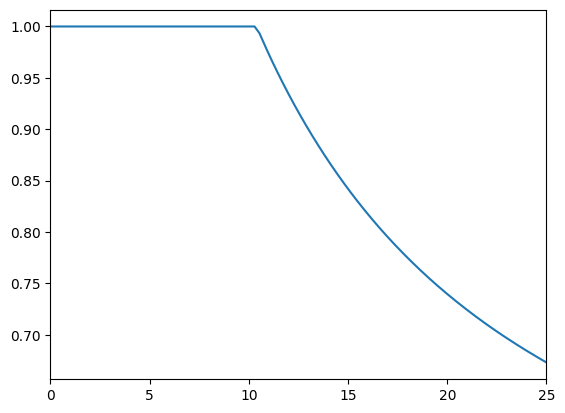

In [7]:
plot_funcs(ShareFunc, 0, 25)

In [8]:
dividend_growth_rate = 1.000203
dividend_std = 0.011983
dividend_shock_std = dividend_std / math.sqrt(dividend_growth_rate)


def price_dividend_ratio_random_walk(DiscFac, CRRA, days_per_quarter=90):
    # Assuming DiscFac in argument in quarterly
    DiscFac_daily = DiscFac ** (1.0 / days_per_quarter)

    subjective_return = (
        dividend_growth_rate ** (1 - CRRA)
        * DiscFac_daily
        * (dividend_shock_std**2 + 1) ** (CRRA * (CRRA - 1) / 2)
    )

    return subjective_return

In [9]:
def compute_target_wealth(
    CRRA=5.0,
    DiscFac=0.9,
    RiskyAvg=1.05,
    RiskyStd=0.20,
    PermShkStd=[0.1],
    TranShkStd=[0.1],
):
    # Replace only exploratory parameters directly in the dictionary
    agent_parameters = {
        **init_portfolio,
        "CRRA": CRRA,
        "DiscFac": DiscFac,
        "RiskyAvg": RiskyAvg,
        "RiskyStd": RiskyStd,
        "PermShkStd": PermShkStd,
        "TranShkStd": TranShkStd,
    }

    agent = SequentialPortfolioConsumerType(**agent_parameters)

    linear_root = np.nan
    cons_at_root = np.nan
    share_at_root = np.nan

    srle1 = price_dividend_ratio_random_walk(DiscFac, CRRA)

    try:
        agent.solve()
        solved = True
    except Exception:
        return False, linear_root, cons_at_root, share_at_root, srle1

    cFunc = agent.solution[0].cFuncAdj
    ShareFunc = agent.solution[0].ShareFuncAdj

    mNrm = cFunc.x_list
    share = ShareFunc.y_list
    cons = cFunc.y_list
    aNrm = mNrm - cFunc.y_list

    mNrm_next = (
        aNrm
        * (
            share * agent.parameters["RiskyAvg"]
            + (1 - share) * agent.parameters["Rfree"]
        )
        + 1  # assuming average income is 1
    )

    criteria = mNrm - mNrm_next
    idx = np.searchsorted(criteria, 0)

    if idx == 0:
        solved = False
        return False, 0.0, 0.0, share_at_root, srle1
    elif idx >= len(criteria) - 1:
        solved = False
        return False, linear_root, cons_at_root, share_at_root, srle1

    # Calculate the difference once and reuse it
    diff_mNrm = mNrm[idx] - mNrm[idx-1]
    diff_cons = cons[idx] - cons[idx-1]
    diff_share = share[idx] - share[idx-1]
    diff_criteria = criteria[idx] - criteria[idx - 1]

    # Compute this term once and reuse it
    ratio = (0 - criteria[idx - 1]) / diff_criteria

    linear_root = mNrm[idx-1] + diff_mNrm * ratio
    cons_at_root = cons[idx-1] + diff_cons * ratio
    share_at_root = share[idx-1] + diff_share * ratio

    return solved, linear_root, cons_at_root, share_at_root, srle1

In [10]:
compute_target_wealth()

(True,
 16.35182266895578,
 1.5969426158477524,
 0.8091703859843569,
 0.9994530880363419)

In [11]:
CRRA_grid = [4.0, 5.0, 6.0]
DiscFac_grid = [0.85, 0.9, 0.95]
RiskyAvg_grid = [1.04, 1.05, 1.06]
RiskyStd_grid = [0.1, 0.2, 0.3]
PermShkStd_grid = [0.0, 0.1, 0.2]
TranShkStd_grid = [0.0, 0.1, 0.2]

In [12]:
lazy_rows = []


for CRRA in CRRA_grid:
    for DiscFac in DiscFac_grid:
        for RiskyAvg in RiskyAvg_grid:
            for RiskyStd in RiskyStd_grid:
                for PermShkStd in PermShkStd_grid:
                    for TranShkStd in TranShkStd_grid:
                        # s, lr, llr, csr = compute_target_wealth(

                        lazy_row = dask.delayed(compute_target_wealth)(
                            CRRA=CRRA,
                            DiscFac=DiscFac,
                            RiskyAvg=RiskyAvg,
                            RiskyStd=RiskyStd,
                            PermShkStd=[PermShkStd],
                            TranShkStd=[TranShkStd],
                        )

                        lazy_rows.append(
                            {
                                "CRRA": CRRA,
                                "DiscFac": DiscFac,
                                "RiskyAvg": RiskyAvg,
                                "RiskyStd": RiskyStd,
                                "PermShkStd": PermShkStd,
                                "TranShkStd": TranShkStd,
                                "lazy_row": lazy_row,
                            }
                        )

In [13]:
lazy_rows = dask.compute(*lazy_rows)

full garbage collection released 12.25 MiB from 4958 reference cycles (threshold: 9.54 MiB)


In [14]:
for row in lazy_rows:
    row["solved"] = 1 * row["lazy_row"][0]
    row["linear_root"] = row["lazy_row"][1]
    row["cons_at_root"] = row["lazy_row"][2]
    row["share_at_root"] = row["lazy_row"][3]
    row["srle1"] = row["lazy_row"][4]

    del row["lazy_row"]

In [15]:
df = pd.DataFrame(lazy_rows)

In [16]:
df.to_csv("roots.csv")

In [17]:
df.corr()

,CRRA,DiscFac,RiskyAvg,RiskyStd,PermShkStd,TranShkStd,solved,linear_root,cons_at_root,share_at_root,srle1
CRRA,1.000000e+00,-1.039977e-15,6.727943e-14,-3.706454e-16,7.881213e-17,3.726443e-16,-9.005994e-02,0.157269,0.072272,-0.246062,5.817601e-01
DiscFac,-1.039977e-15,1.000000e+00,3.404796e-14,-5.343377e-16,1.674044e-16,5.889493e-17,-4.760311e-01,0.453445,0.171608,-0.278521,8.114308e-01
RiskyAvg,6.727943e-14,3.404796e-14,1.000000e+00,2.515974e-15,5.648559e-16,2.146096e-16,-1.672542e-01,0.020508,0.217313,0.113006,6.322922e-14
RiskyStd,-3.706454e-16,-5.343377e-16,2.515974e-15,1.000000e+00,-7.138780e-19,-2.498573e-18,3.731055e-01,0.180254,-0.134453,-0.593681,-2.489527e-15
PermShkStd,7.881213e-17,1.674044e-16,5.648559e-16,-7.138780e-19,1.000000e+00,1.070817e-17,-2.058513e-01,0.584474,0.542382,-0.579252,-3.813244e-15
TranShkStd,3.726443e-16,5.889493e-17,2.146096e-16,-2.498573e-18,1.070817e-17,1.000000e+00,-6.070616e-17,0.004314,0.008180,-0.006458,-1.148223e-15
solved,-9.005994e-02,-4.760311e-01,-1.672542e-01,3.731055e-01,-2.058513e-01,-6.070616e-17,1.000000e+00,NaN,NaN,NaN,-4.372525e-01
linear_root,1.572693e-01,4.534447e-01,2.050782e-02,1.802543e-01,5.844742e-01,4.313946e-03,NaN,1.000000,0.718891,-0.679697,4.591787e-01
cons_at_root,7.227171e-02,1.716075e-01,2.173128e-01,-1.344528e-01,5.423823e-01,8.180356e-03,NaN,0.718891,1.000000,-0.254124,1.840540e-01
share_at_root,-2.460624e-01,-2.785213e-01,1.130058e-01,-5.936812e-01,-5.792524e-01,-6.457794e-03,NaN,-0.679697,-0.254124,1.000000,-3.720842e-01


In [18]:
df["solved"].sum()

591

In [19]:
df

,CRRA,DiscFac,RiskyAvg,RiskyStd,PermShkStd,TranShkStd,solved,linear_root,cons_at_root,share_at_root,srle1
0,4.0,0.85,1.04,0.1,0.0,0.0,1,1.455464,1.017518,1.000000,0.998448
1,4.0,0.85,1.04,0.1,0.0,0.1,1,1.473427,1.018209,1.000000,0.998448
2,4.0,0.85,1.04,0.1,0.0,0.2,1,1.532810,1.020493,1.000000,0.998448
3,4.0,0.85,1.04,0.1,0.1,0.0,1,1.643901,1.024765,1.000000,0.998448
4,4.0,0.85,1.04,0.1,0.1,0.1,1,1.672771,1.025876,1.000000,0.998448
...,...,...,...,...,...,...,...,...,...,...,...
724,6.0,0.95,1.06,0.3,0.1,0.1,1,89.080351,2.065414,0.204069,1.000569
725,6.0,0.95,1.06,0.3,0.1,0.2,1,89.091366,2.065098,0.203982,1.000569
726,6.0,0.95,1.06,0.3,0.2,0.0,0,NaN,NaN,NaN,1.000569
727,6.0,0.95,1.06,0.3,0.2,0.1,0,NaN,NaN,NaN,1.000569
